In [649]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

import torch
from torchsummary import summary
import torch.utils.data as data_utils

from tqdm import tqdm

In [650]:
# Constants

FOLDER = 'data/'
CMAP = "YlGnBu"
TARGET = "gross"
BATCH_SIZE = 50

### Dataset analysis

Link: http://archive.ics.uci.edu/dataset/2/adult

In [651]:
!ls data/

Index  adult.data  adult.names	adult.test  adult.zip  old.adult.names


In [652]:
with open(FOLDER + "Index", "r") as f:
    print(f.read())

Index of adult

02 Dec 1996      140 Index
10 Aug 1996  3974305 adult.data
10 Aug 1996     4267 adult.names
10 Aug 1996  2003153 adult.test



In [653]:
# file with intro about dataset
# let's parse column names and types
with open(FOLDER + "adult.names", "r") as f:
    adult_names_file = f.read()

In [654]:
parsed_columns = adult_names_file.split("\n\n\n>50K, <=50K.\n\n")[1]
splited_columns = parsed_columns.split("\n")

# order for reading files with data
features_names = []
# list of numerical features
numerical_features_list = []
# dict of categorical features with possible values
categorical_features_dict = {}

# !!!
# adding special target feature
target_name = [TARGET]

In [655]:
for row in splited_columns:
    if row == "":
        continue
    row = row.rstrip(".")
    name, values = row.split(": ")
    features_names.append(name)
    if values == 'continuous':
        numerical_features_list.append(name)
    else:
        categorical_features_dict[name] = values.split(", ")

In [656]:
data = pd.read_csv(FOLDER + "adult.data", sep=", ", names=features_names + target_name, index_col=False)
print(f"Data size is {data.shape[0]}")

Data size is 32561


In [657]:
# Let's check data integrity
# Change all strange values in 
# categoricaal columns to null

for feature, values in categorical_features_dict.items():
    data[feature] = data[feature].apply(lambda x: np.nan if x not in values else x)

print(data.isna().sum())

# as we can see, column 'workclass', 'occupation', 'native-country' have NaN values

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
gross                0
dtype: int64


In [658]:
# target column has only two values
# so, it's Rregression task

print("Target column values:")
print(*data[TARGET].drop_duplicates().values)

Target column values:
<=50K >50K


In [659]:
####################
### Task:
#####################
# Prediction task is to determine whether a person makes over 50K a year.
# Features:
### Numerical: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week
### Categorical: workclass, education, marital-status, occupation, relationship, race, sex, native-country

### Data Visualization
#### Source: https://en.wikipedia.org/wiki/Quartile

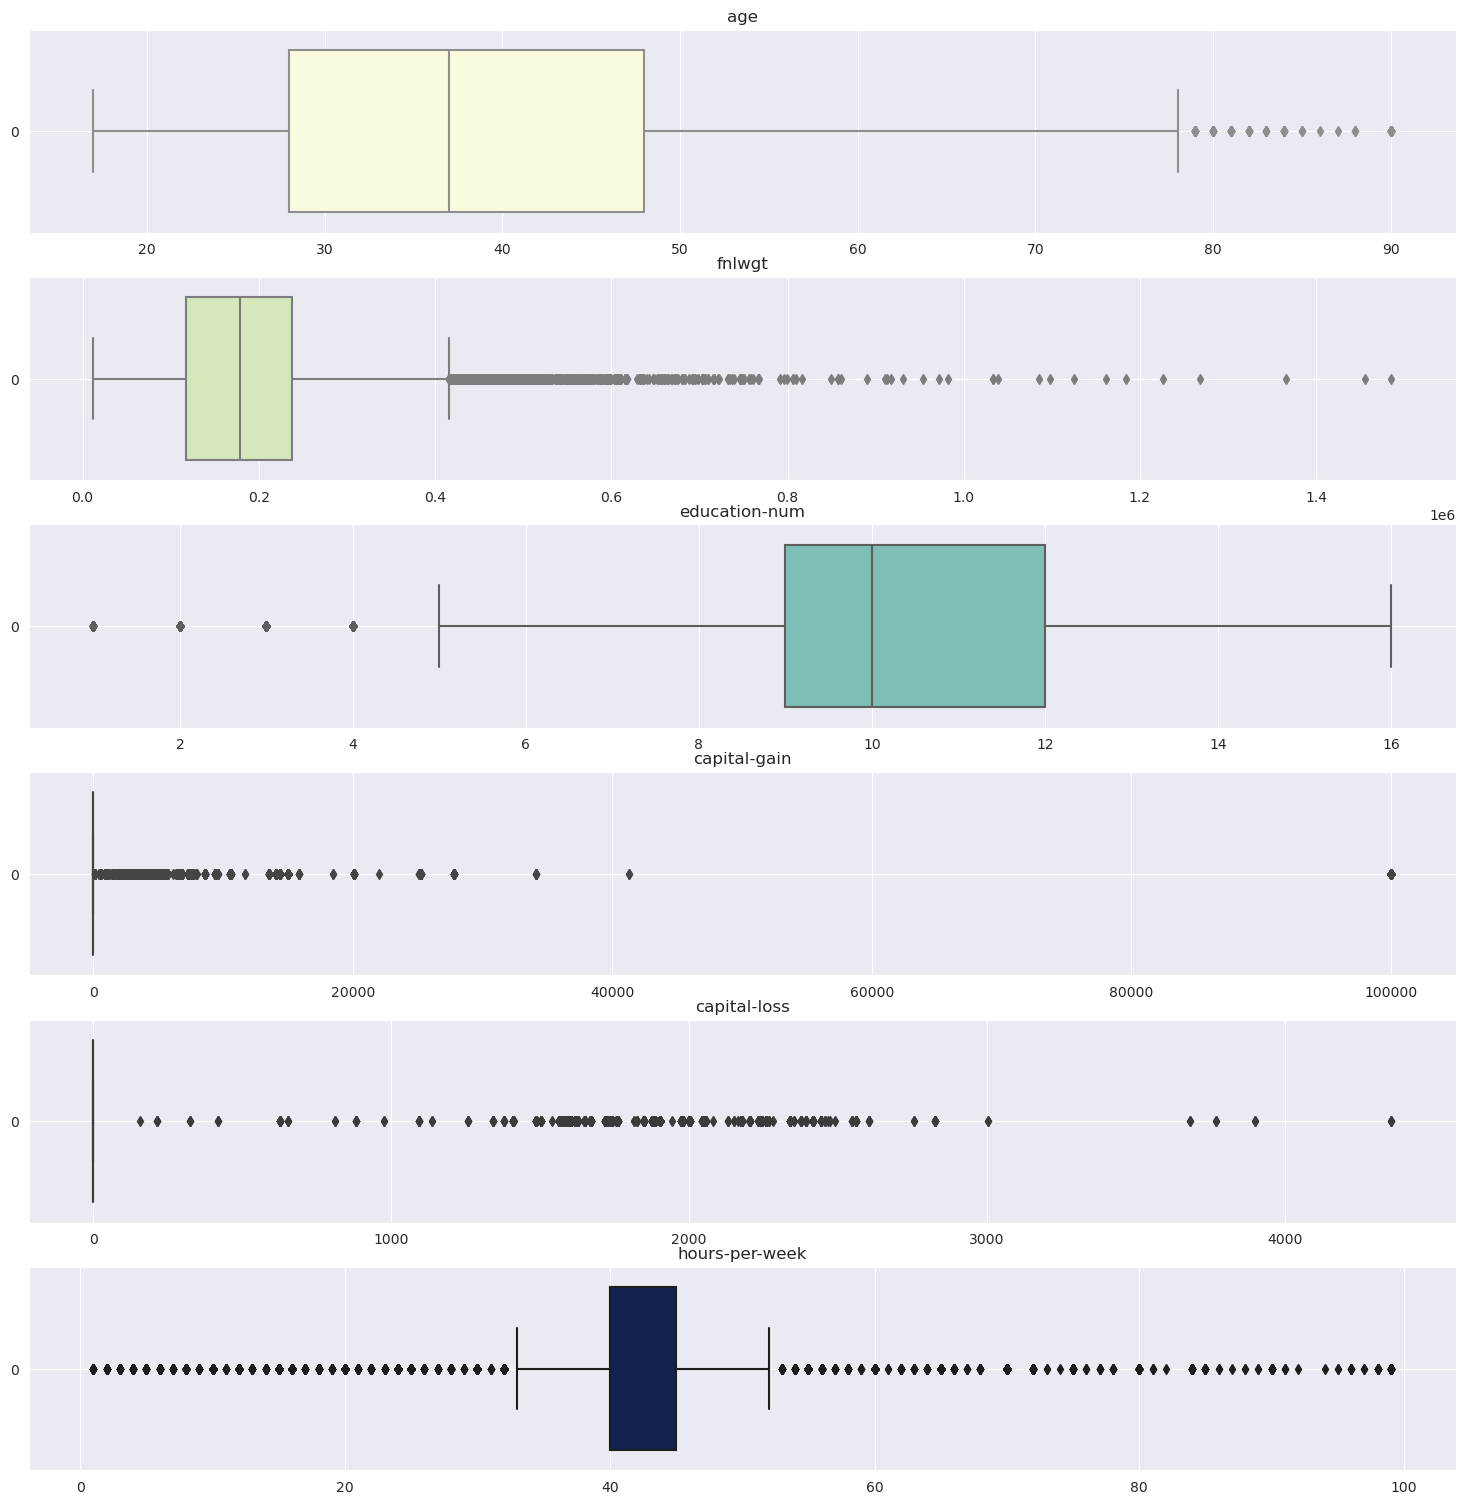

In [660]:
# numeric data visualization with Box-and-Whisker
n = len(numerical_features_list)

fig, axes = plt.subplots(n)
fig.set_size_inches(15, 15)
fig.tight_layout()

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, n)]

for (ax, col, color) in zip(axes, numerical_features_list, colors):
    sns.boxplot(data=data[col].values, orient='h', ax=ax, color=color).set_title(col)
    ax.grid()

plt.show()

In [661]:
# let's see share of outlier in numerical features

n = len(numerical_features_list)

for col in numerical_features_list:
    array = data[col].values
    q1, q3 = np.quantile(array, 0.25), np.quantile(array, 0.75)
    iqr = q3 - q1
    upper_bound, lower_bound = q3 + (1.5 * iqr), q1 - (1.5 * iqr)
    array_bl = ((array < lower_bound) | (array > upper_bound))
    print(f"{col}: share of outlier is {round(100 * np.sum(array_bl) / len(array_bl), 2)}%")

age: share of outlier is 0.44%
fnlwgt: share of outlier is 3.05%
education-num: share of outlier is 3.68%
capital-gain: share of outlier is 8.33%
capital-loss: share of outlier is 4.67%
hours-per-week: share of outlier is 27.66%


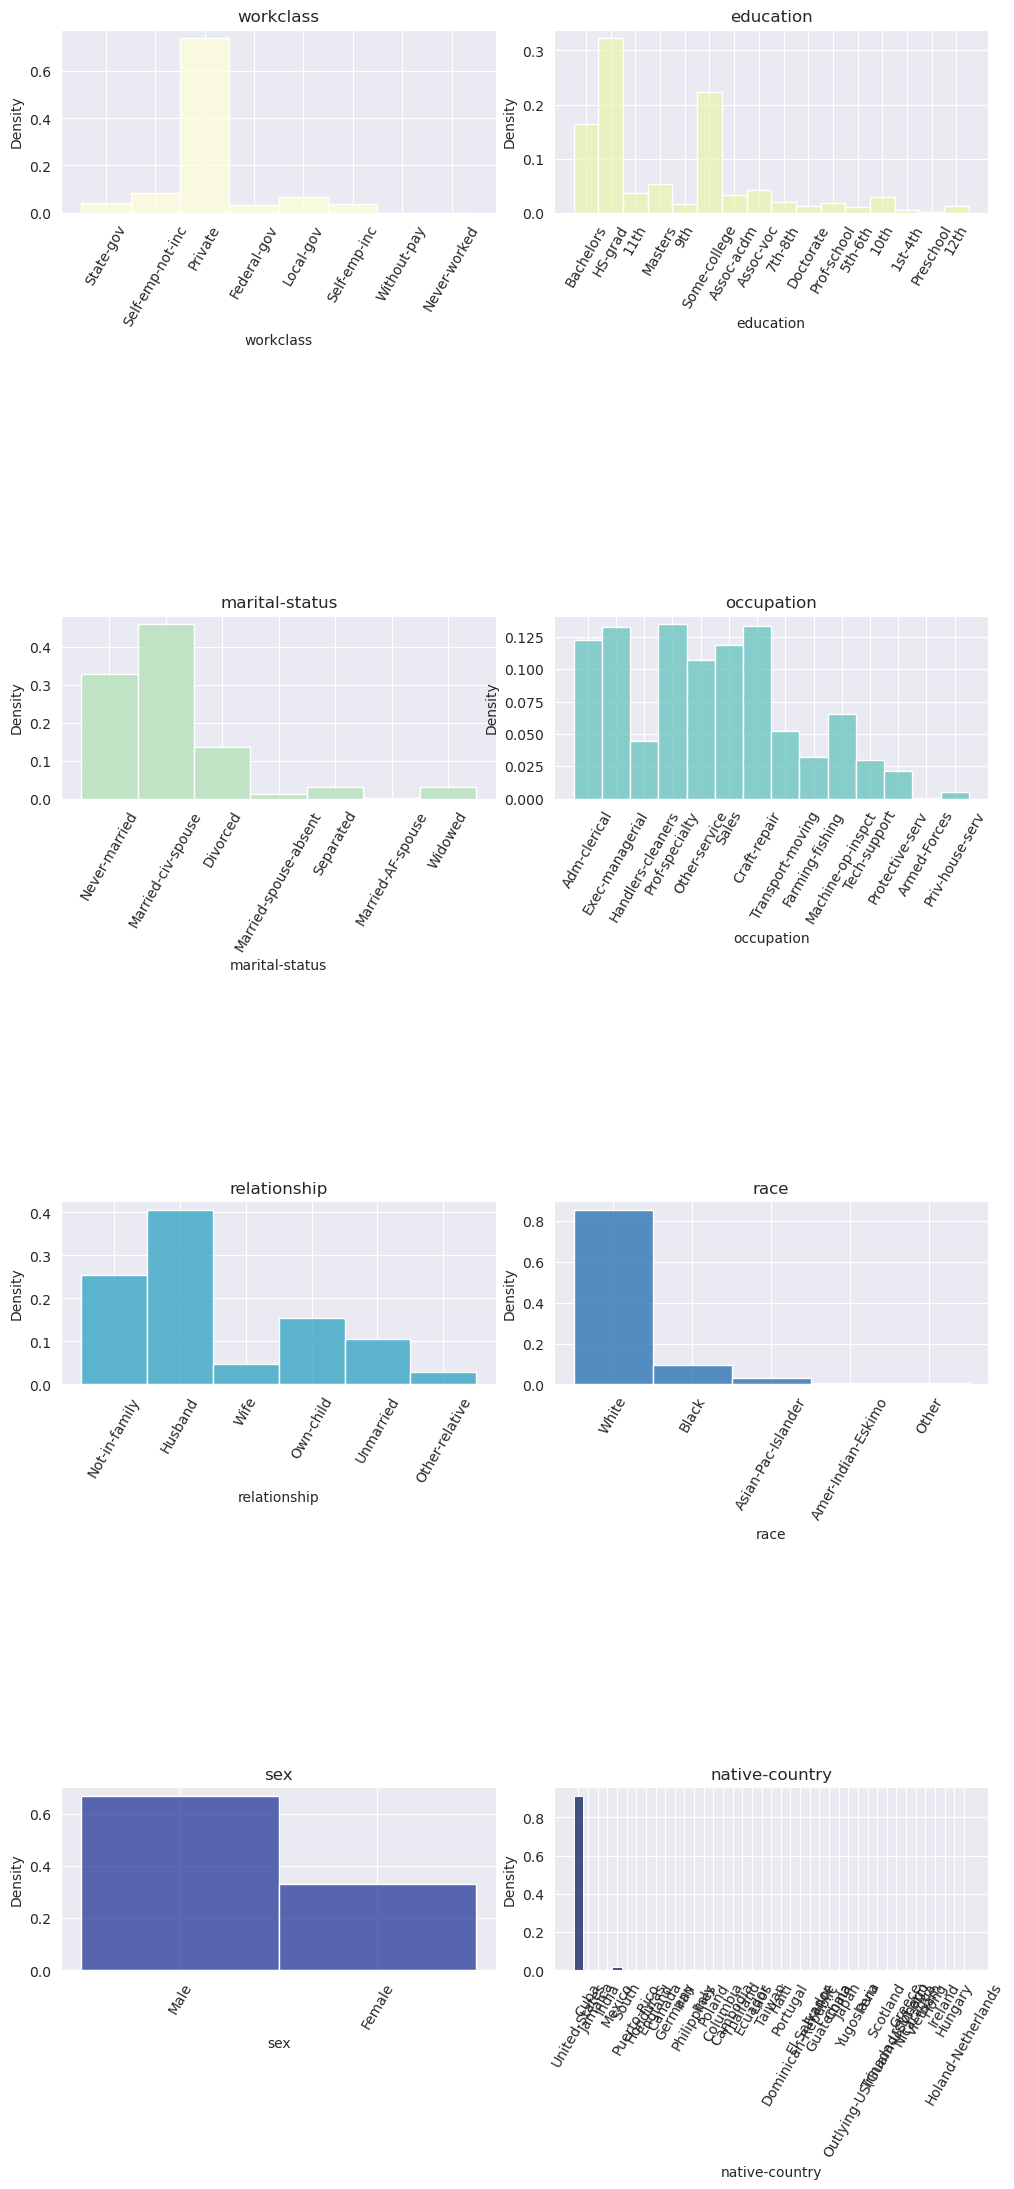

In [662]:
# hists for categorical features

m = len(categorical_features_dict)

n_row = 4
if m % n_row != 0:
    raise ValueError("Not int")
n_col = int(m / n_row)

fig, axes = plt.subplots(n_row, n_col)
fig.set_size_inches(n_col * 5, n_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 2.2)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, m)]

for (ax, col, color) in zip(axes.flatten(), categorical_features_dict.keys(), colors):
    sns.histplot(data=data, x=col, ax=ax, color=color, stat='density').set(title=col)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=60)

plt.show()

In [663]:
# let's see more carefully to 'native-country' column
nc = data['native-country'].value_counts().reset_index()
nc['ttl'] = nc['native-country'].sum()
nc['share, %'] = 100 * nc['native-country'] / nc['ttl']
nc.head(1)

,index,native-country,ttl,"share, %"
0,United-States,29170,31978,91.218963


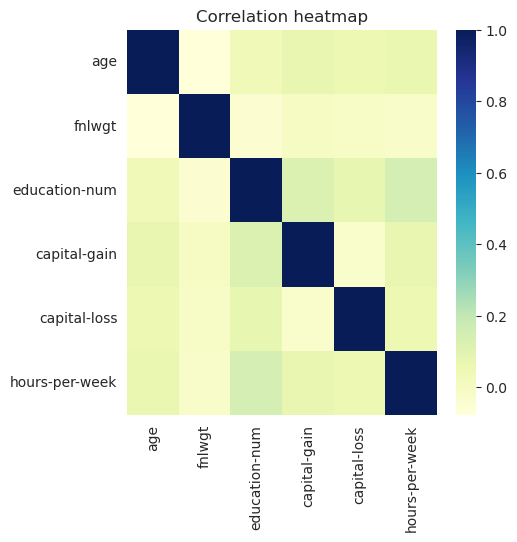

In [664]:
# correlation heatmap

fig = plt.figure(figsize=(5, 5))    
corr = data[numerical_features_list].corr()
sns.heatmap(corr, cmap=CMAP)
plt.title("Correlation heatmap")
plt.show()

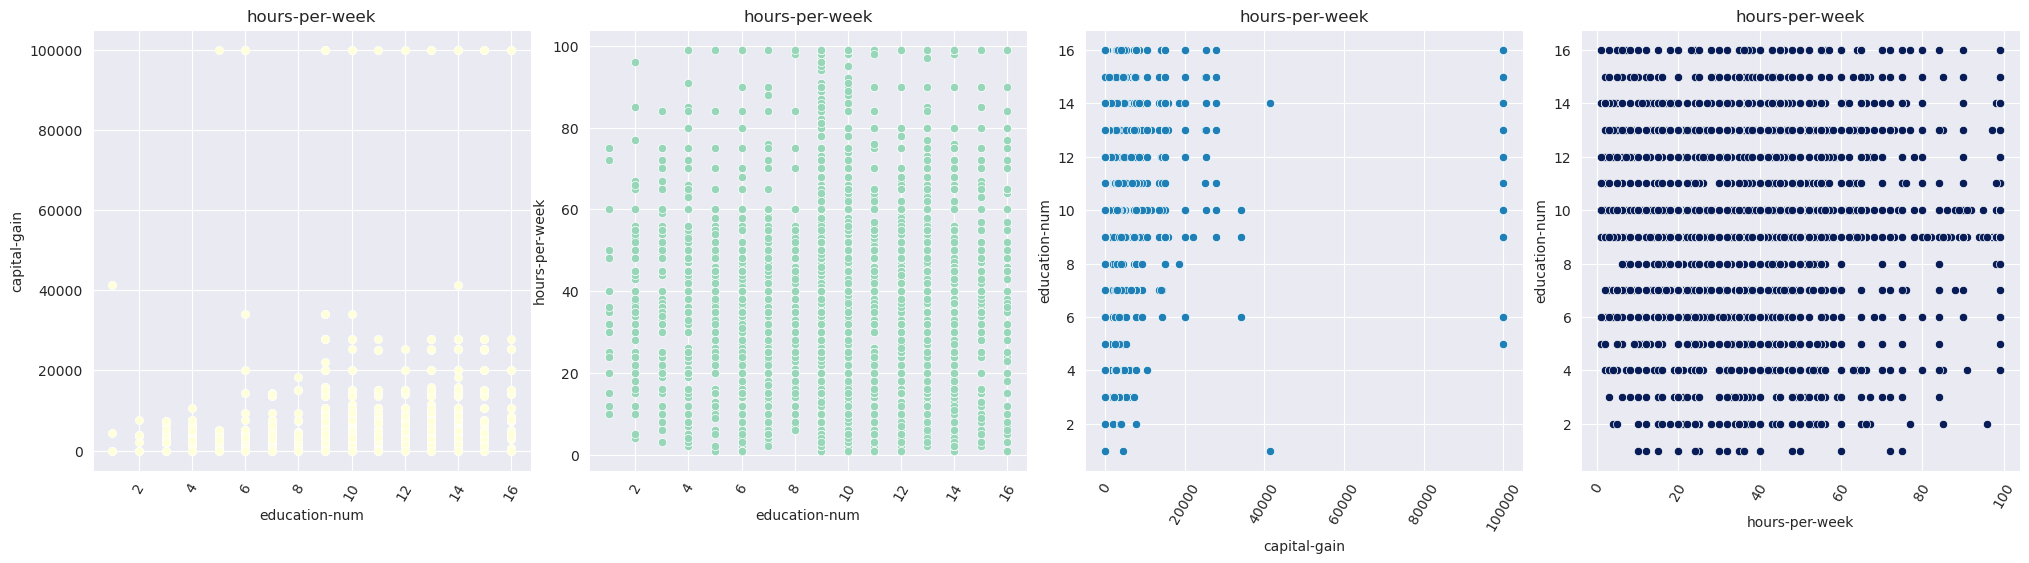

In [665]:
# scatter plot


# let's analyse only column with
# high value of correlation
to_scatter = []
for ind in corr.index:
    for col in corr.columns:
        if (np.abs(corr.loc[ind, col]) >= 0.10) & (ind != col):
            to_scatter.append((ind, col))

k = len(to_scatter)

k_row = 1
if k % k_row != 0:
    raise ValueError("Not int")
k_col = int(k / k_row)

fig, axes = plt.subplots(k_row, k_col)
fig.set_size_inches(k_col * 5, k_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 2.2)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for (ax, cols, color) in zip(axes.flatten(), to_scatter, colors):
    sns.scatterplot(data=data, x=cols[0], y=cols[1], ax=ax, color=color).set(title=col)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=60)

plt.show()        

In [666]:
##############################################
### Conclusion:
##############################################

# 1) Column 'workclass', 'occupation', 'native-country' have NaN values;
# 2) Column 'native-country' have more than 91% value 'United States';
# 3) Based on correlation and scatter analysis, we can say, that numerical features are not correlated.

### Prepocessing

In [667]:
# duplicated

print(f"Dataset has {data.duplicated().sum()} duplicates.")
processed_data = data.drop_duplicates()

Dataset has 24 duplicates.


In [668]:
# before preprocessing and normalization let's create new features
# First, diff between capital loss and capital gain
data['capital-diff'] = data['capital-gain'] - data['capital-loss']
x = data['capital-diff'].values.reshape(-1, 1)
y = StandardScaler().fit_transform(x)
data['capital-diff'] = y

# Second, ratio between age and education
data['edu2age'] = data['education-num'] / data['age']
x = data['edu2age'].values.reshape(-1, 1)
y = StandardScaler().fit_transform(x)
data['edu2age'] = y

numerical_features_list.extend(['capital-diff', 'edu2age'])
features_names.extend(['capital-diff', 'edu2age'])

In [669]:
# outliers + preprocessing
# https://towardsdatascience.com/dont-throw-away-your-outliers-c37e1ab0ce19

############################################################################
# age. min - 17, max - 90
# All outliers are logically explained.
# We don't need to preprocess outliers, so
# let's use RobustScaler to preprocess feature.
x = data['age'].values.reshape(-1, 1)
y = RobustScaler().fit_transform(x).flatten()
data['age'] = y

############################################################################
# fnlwgt. min - 12285, max - 1484705
# feature - amount of people who have same other features
# https://www.kaggle.com/code/phinnik/fnlwgt
# This feature logically depends from other.
# So, it can be removed. Now we can winsorize it.
# After that, use StandardScaler
x = data['fnlwgt'].values.reshape(-1, 1)
y = winsorize(x, [0.05, 0.05])
y = StandardScaler().fit_transform(y)
data['fnlwgt'] = y

############################################################################
# education-num. min - 1, max - 16
# education-num - years of education
# All outliers are lower than lower bound
# It can be possible, because people can have 
# 1-5 years education, if they didn't end university. 
# Let's use RobustScaler to preprocess feature.
x = data['education-num'].values.reshape(-1, 1)
y = RobustScaler().fit_transform(x).flatten()
data['education-num'] = y

############################################################################
# capital-gain. min - 0, max - 99999
# median value - 0, max - 99999
# Strange max results and values after upper bound
# So, let's use winsorize high level to 95% percentile
# And use StandardScaler after.
x = data['capital-gain'].values.reshape(-1, 1)
y = winsorize(x, [0, 0.05])
y = StandardScaler().fit_transform(y).flatten()
data['capital-gain'] = y

############################################################################
# capital-loss. min - 0, max - 4356
# median value - 0, max - 4356
# Don't need to cut values, because there aren't
# so many values which are upper than 0
# So, use StandardScaler.
x = data['capital-loss'].values.reshape(-1, 1)
y = StandardScaler().fit_transform(x).flatten()
data['capital-loss'] = y

############################################################################
# hours-per-week. min - 1, max - 99
# median value - 40, max - 99
# Strange results out of box
# So, let's use winsorize.
# And StandardScaler after.
x = data['hours-per-week'].values.reshape(-1, 1)
y = winsorize(x, [0.05, 0.05])
y = StandardScaler().fit_transform(y).flatten()
data['hours-per-week'] = y

In [670]:
# missing values
# https://www.scaler.com/topics/data-science/categorical-missing-values/
# Columns 'workclass', 'occupation', 'native-country'

# columns 'workclass', 'native-country' have the most frequent values
# so, we can use imputer with mode

impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(data[['workclass', 'native-country']])

data[['workclass', 'native-country']] = impute_mode.transform(data[['workclass', 'native-country']])

In [671]:
# Column 'occupation' has a more complex distribution
# so, we will use KNN-imputer 
# but, before using it, we need to encode categorical values

for col_name, col_values in categorical_features_dict.items():
    print(f"{col_name} have {len(set(col_values))} unique values")

# limited count of values, so, we can use LabelEncoder
# firstly, save nan-values

original = data.copy()
mask = data.isnull()
data[list(categorical_features_dict.keys())] = data[list(categorical_features_dict.keys())].apply(LabelEncoder().fit_transform)
data = pd.DataFrame(np.where(mask, original, data), columns=original.columns)

workclass have 8 unique values
education have 16 unique values
marital-status have 7 unique values
occupation have 14 unique values
relationship have 6 unique values
race have 5 unique values
sex have 2 unique values
native-country have 41 unique values


In [672]:
# after all, using KNNEncoder
imputer = KNNImputer(n_neighbors = 3)
new_data = pd.DataFrame(imputer.fit_transform(data[features_names]), columns = features_names)
data = pd.concat([new_data, data[TARGET]], axis=1)
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
capital-diff      0
edu2age           0
gross             0
dtype: int64

In [673]:
# Standard Scaler to dummy-cat features

for col in categorical_features_dict.keys():
    data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1, 1)).flatten()

In [674]:
# output preprocessing
idx2label = list(set(data[TARGET].values))
label2idx = {k:v for v, k in enumerate(idx2label)}
data[TARGET] = data[TARGET].apply(lambda x: label2idx[x])

### Feature selection

In [675]:
# New features we created before
# numeric data preprocessing.
# We did it there, because we need to 
# use original data

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif


X, y = data[features_names].values, data[TARGET].values

# Now, let's choose features based on k-selector
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
print(*selector.get_feature_names_out(features_names))

X = selector.transform(X)

age education education-num marital-status relationship sex capital-gain capital-loss hours-per-week capital-diff


In [676]:
y_train.reshape(-1, 1)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [677]:
# params


N = X.shape[0]
n_features = X.shape[1]

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=1/3, random_state=1) # 0.33 x 0.9 = 0.397

y_train = torch.Tensor(y_train.reshape(-1, 1))
X_train = torch.Tensor(X_train)
train_dataset = data_utils.TensorDataset(X_train, y_train)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

y_val = torch.Tensor(y_val.reshape(-1, 1))
X_val = torch.Tensor(X_val)
val_dataset = data_utils.TensorDataset(X_val, y_val)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

y_test = torch.Tensor(y_test.reshape(-1, 1))
X_test = torch.Tensor(X_test)
test_dataset = data_utils.TensorDataset(X_test, y_test)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model architecture

In [678]:
class PolynomialModel(torch.nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_features, 10)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(10, 10)
        self.linear3 = torch.nn.Linear(10, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.sigmoid(x)
        return x
    
    def init_weights(self):
        torch.nn.init.xavier_uniform(self.linear1.weight)
        self.linear1.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform(self.linear2.weight)
        self.linear2.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform(self.linear3.weight)
        self.linear3.bias.data.fill_(0.01)

In [679]:
model = PolynomialModel(n_features)
model.init_weights()

summary(model, input_size=(10, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
              Tanh-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              Tanh-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
              Tanh-6                    [-1, 1]               0
           Sigmoid-7                    [-1, 1]               0
Total params: 231
Trainable params: 231
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [680]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = torch.nn.BCELoss()

In [681]:
def process(train_dataloader, val_dataloader, optim, loss_fn, epochs):

    for e in range(epochs):
        model.train()
        running_loss = 0.0
        last_loss = 0.0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            optim.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)

            loss.backward()
            optim.step()

            running_loss += loss.item()

            if i % 10 == 9:
                last_loss = running_loss / 10
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.
        
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss



     avg_vloss = running_vloss / (i + 1)
        print('Epoch {}: loss train {} valid {}'.format(e, last_loss, avg_vloss))

In [682]:
process(train_dataloader, val_dataloader, optim, loss_fn, 20)

  batch 10 loss: 0.6314182162284852
  batch 20 loss: 0.5642142295837402
  batch 30 loss: 0.5435641139745713
  batch 40 loss: 0.5077642947435379
  batch 50 loss: 0.5156551659107208
  batch 60 loss: 0.5043720453977585
  batch 70 loss: 0.4756566762924194
  batch 80 loss: 0.48879413604736327
  batch 90 loss: 0.4649356693029404
  batch 100 loss: 0.4906976819038391
  batch 110 loss: 0.49055768847465514
  batch 120 loss: 0.46941227912902833
  batch 130 loss: 0.4755243808031082
  batch 140 loss: 0.4550047546625137
  batch 150 loss: 0.48386942148208617
  batch 160 loss: 0.46391057670116426
  batch 170 loss: 0.47625798285007476


  batch 180 loss: 0.5001955091953277
  batch 190 loss: 0.48505560457706454
  batch 200 loss: 0.47100323140621186
  batch 210 loss: 0.48848146200180054
  batch 220 loss: 0.49226288199424745
  batch 230 loss: 0.48265951573848725
  batch 240 loss: 0.4703597456216812
  batch 250 loss: 0.5041264146566391
  batch 260 loss: 0.47877945601940153
  batch 270 loss: 0.4592267245054245
  batch 280 loss: 0.4612955331802368
  batch 290 loss: 0.46153939664363863
  batch 300 loss: 0.48030540347099304
  batch 310 loss: 0.48236065208911894
  batch 320 loss: 0.4789499878883362
  batch 330 loss: 0.4761127769947052
  batch 340 loss: 0.4896668165922165
  batch 350 loss: 0.4627985328435898
  batch 360 loss: 0.47339863181114195
  batch 370 loss: 0.4681159734725952
  batch 380 loss: 0.4844822287559509
  batch 390 loss: 0.4604194492101669
Epoch 0: loss train 0.4604194492101669 valid 0.47946038842201233
  batch 10 loss: 0.48350406885147096
  batch 20 loss: 0.4828502207994461
  batch 30 loss: 0.4761755049228668
  